# General

In [1]:
# imports
from scipy.optimize import curve_fit
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Functions

In [3]:
def get_data(file_path, dark = True, cali = True, cut = [506,545]):
    '''
    take raw data and transform it to pd data frame 
    '''
    cali_params1 = [-5.752597903601357, 1.0042432321536299]
    cali_func1 = lambda x: cali_params1[1] * x + cali_params1[0]
    
    data = pd.read_csv(file_path, delimiter='\t' ,names = ['x', 'y'])
    
    if cali:
        data['x'] = cali_func1(data['x'])
        
    data = data[(data['x'] > cut[0]) & (data['x'] < cut[1])]

    if dark:
        data['y'] = data['y'] - dark_data['y']
    return data

def calc_absorption(data):
    '''
    calculate absorption from raw data
    '''
    return np.array(-np.log10(data['y']/blank_data['y']))

def wavelength_to_wavenumber(wavelength):
    return 1 / wavelength * 1e7 # nm to cm^-1

def plot_spectrom(data, title = 'Spectrum', x_type = 'nm'):
    if x_type == 'cm^-1':
        x_label = r'Wavenumber [$cm^{-1}$]'
        data['x'] = wavelength_to_wavenumber(data['x'])
    else:
        x_label = 'Wavelength [nm]'

    plt.plot(data['x'], data['y'])
    plt.title(title, fontsize=18)
    plt.xlabel(x_label)
    plt.ylabel('Intensity [a.u.]')
    plt.show()

def linear_func(x, a, b):
    return a * x + b

def Birge_Sponer (peaks_df,show_ext = False, title =''):
    # Perform the curve fit
    popt, pcov = curve_fit(linear_func, peaks_df['level'] + 1, peaks_df['Deltawavenumber'])

    # Extract the fitting parameters
    a, b = popt
    da, db = np.sqrt(np.diag(pcov))

    # Plot the data and the fit
    plt.plot(peaks_df['level'] + 1, peaks_df['Deltawavenumber'], '.', label='Data')
    plt.plot(peaks_df['level'] + 1, linear_func(peaks_df['level'] + 1, *popt), '-', label='Fit')
    plt.xlabel(r'$\nu + 1$')
    plt.ylabel(r'$\Delta\widetilde{\nu}$ [cm$^{-1}$]')
    plt.title('The Birge-Sponer Extrapolation' + title, fontsize=18)


    #culate things
    ve, dve = b, db
    vexe, dvexe = - a / 2, da / 2
    D0, dD0 = - b ** 2 / (2 * a), np.sqrt((b * db / a) ** 2 + (b ** 2 * da / (2 * a ** 2)) ** 2)
    De, dDe = D0 + ve / 2, np.sqrt(dD0 ** 2 + (dve / 2) ** 2)

    vdelta =  peaks_df['level'].values[0] + 1
    A,dA = 1 /2 * (a * vdelta + b) * (-b/a - vdelta), np.sqrt((1 /2 * (a * vdelta + b) * (-b/a - vdelta))**2 * ( (db / 2)**2 + (da * vdelta / 2)**2) + (1 /2 * (a * vdelta + b) * (-b/a - vdelta) * (a * vdelta / 2))**2)
    E_star, dE_star = A + peaks_df['Deltawavenumber'].values[0], np.sqrt(dA ** 2 + peaks_df['Deltawavenumber'].values[0] ** 2)

    if show_ext:
        v_show = np.linspace(0, -b/a, 100)
        plt.plot(v_show, a * v_show + b, '--', color = 'tab:orange', label='Ext.')
        v_show2 = np.linspace(vdelta, -b/a, 100)
        # plt.fill_between(v_show, a * v_show + b, alpha=0.2, color='tab:green', label=r'$D_0 ^{\prime}$')
        plt.fill_between(v_show2, a * v_show2 + b, alpha=0.2, color='tab:orange', label='A')
        plt.xlim(0)
        plt.ylim(0)

    plt.legend()
    plt.show()
    return ve, dve, vexe, dvexe, D0, dD0, De, dDe, E_star, dE_star

def do_the_thing(T =25, n1 = 23, **kwargs):
    file_path =os.path.join(Absorption_folder, str(T) + 'c.csv')
    title = ' | T = ' + str(T) + r'$^{\circ}C$'
    data = get_data(file_path, cali = True)
    wavelength = np.array(data['x'])
    absorption = calc_absorption(data)
    peaks, _ = find_peaks(absorption, height = 0.1)
    plt.plot(wavelength, absorption)
    plt.scatter(wavelength[peaks], absorption[peaks], c = 'r', marker = 'x')
    
    plt.title('Absorption Spectrum' + title, fontsize=18)
    plt.xlabel('Wavelength [nm]')
    plt.ylabel('Absorption [a.u.]')
    # plt.xlim(510, 550)
    # plt.xlim(500, 510)
    
    # plt.vlines([541.2,536.9], 0.35,0.45 , color = 'g', linestyle = '--')
    # plt.vlines(wavelength[[peaks[23],peaks[25]]], 0.35,0.45 , color = 'b', linestyle = '--')
    ylim = plt.gca().get_ylim()
    plt.vlines(541.2, ylim[0],ylim[1] , color = 'tab:green', linestyle = '--', label = r'$\nu ^{\prime} = 27$')
    plt.vlines(536.9, ylim[0],ylim[1] , color = 'tab:orange', linestyle = '--', label = r'$\nu ^{\prime} = 29$')
    plt.legend()
    plt.show()
    
    v1 = 29
    
    N = len(peaks)
    levels = np.arange(v1+n1,v1+n1-N,-1)
    # print(levels)
    # print(wavelength[[peaks[23],peaks[25]]])
    peaks_df = pd.DataFrame({'wavelength': wavelength[peaks], 'absorption': absorption[peaks], 'wavenumber': wavelength_to_wavenumber(wavelength[peaks]), 'level': levels})
    peaks_df['Deltawavenumber'] = abs(peaks_df['wavenumber'].diff())
    # display(peaks_df)
    peaks_df = peaks_df.dropna()
    ve, dve, vexe, dvexe, D0, dD0, De, dDe, E_star, dE_star = Birge_Sponer(peaks_df, title=title,  **kwargs)
    print('Results for T=' + str(T) + 'C:')
    print('ve = {:.2f} ± {:.2f} cm^-1'.format(ve, dve))
    print('vexe = {:.2f} ± {:.2f} cm^-1'.format(vexe, dvexe))
    print('D0 = {:.2f} ± {:.2f} cm^-1'.format(D0, dD0))
    print('De = {:.2f} ± {:.2f} cm^-1'.format(De, dDe))
    print('E* = {:.2f} ± {:.2f} cm^-1'.format(E_star, dE_star))
    return [ve, dve, vexe, dvexe, D0, dD0, De, dDe, E_star, dE_star]


# Files

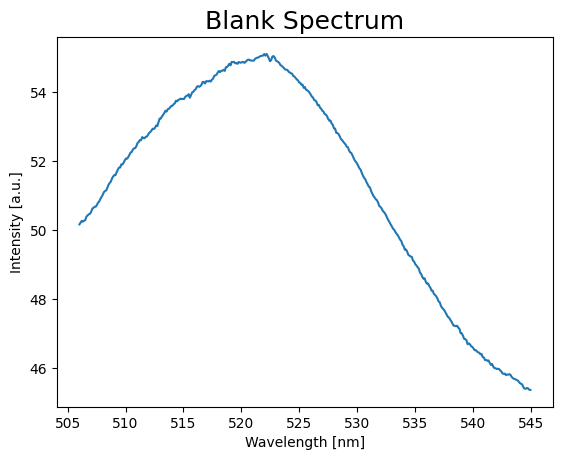

In [20]:

Absorption_folder = 'Absorption_Data'
dark_file = os.path.join(Absorption_folder, 'dark_high_res.csv')
dark_data = get_data(dark_file, cali = True, dark = False)
blank_file = os.path.join(Absorption_folder, 'blank_high_res.csv')
blank_data = get_data(blank_file)

# plot_spectrom(dark_data, title = 'Dark Spectrum', x_type = 'nm')
plot_spectrom(blank_data, title = 'Blank Spectrum', x_type = 'nm')


# Analyzis

## All specta on one graph

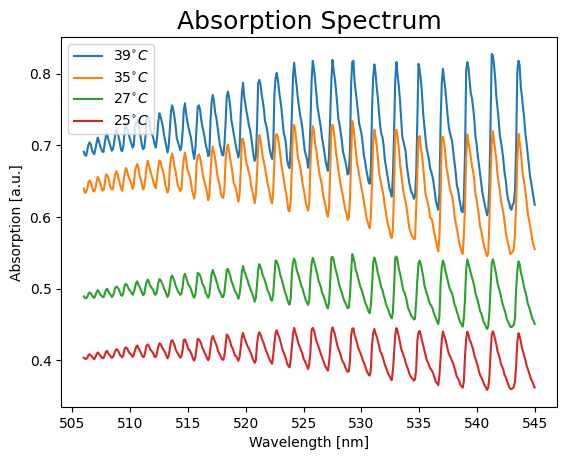

In [19]:
T_list = [25,27,35,39]
for T in T_list[::-1]:
    file = os.path.join(Absorption_folder, str(T) + 'c.csv')
    data = get_data(file, cali = True)
    wavelength = np.array(data['x'])
    absorption = calc_absorption(data)
    plt.plot(wavelength, absorption, label = str(T) + r'$^{\circ}C$')
plt.legend()
plt.title('Absorption Spectrum', fontsize=18)
plt.xlabel('Wavelength [nm]')
plt.ylabel('Absorption [a.u.]')
plt.show()


## Do the thing

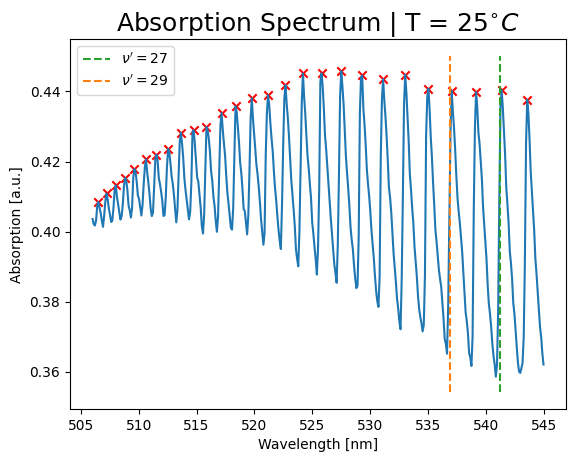

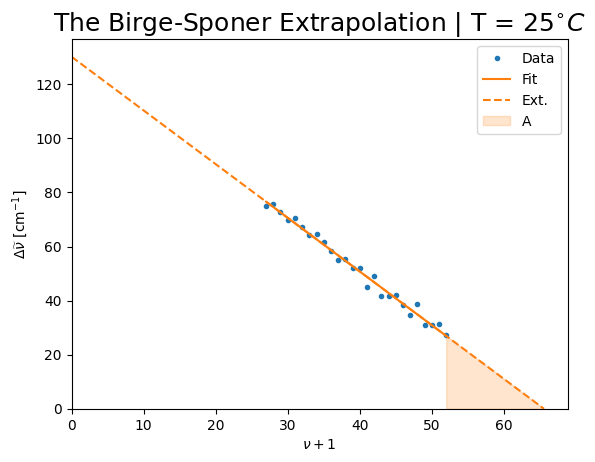

Results for T=25C:
ve = 130.23 ± 1.91 cm^-1
vexe = 0.99 ± 0.02 cm^-1
D0 = 4269.00 ± 161.52 cm^-1
De = 4334.12 ± 161.52 cm^-1
E* = 209.96 ± 9435.53 cm^-1


In [44]:

T = 25
res = do_the_thing(T=T, n1 = 23, show_ext = True)

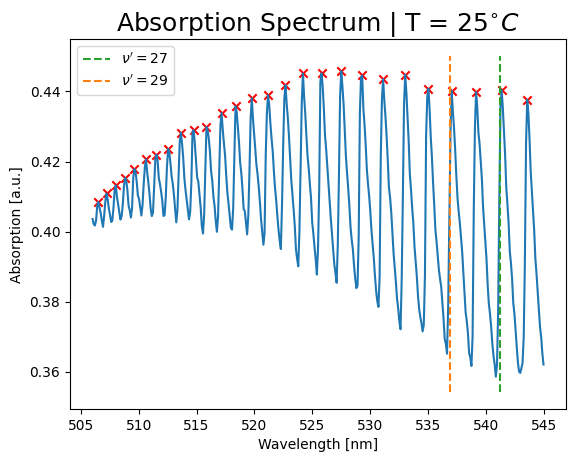

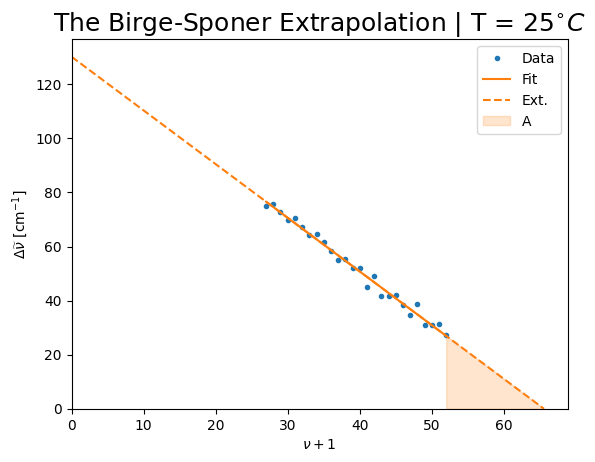

Results for T=25C:
ve = 130.23 ± 1.91 cm^-1
vexe = 0.99 ± 0.02 cm^-1
D0 = 4269.00 ± 161.52 cm^-1
De = 4334.12 ± 161.52 cm^-1
E* = 209.96 ± 9435.53 cm^-1


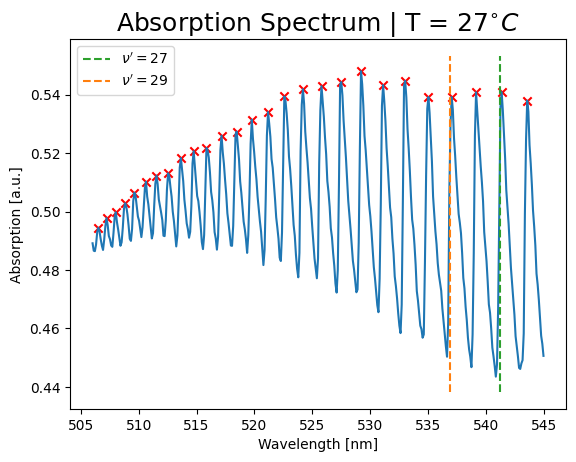

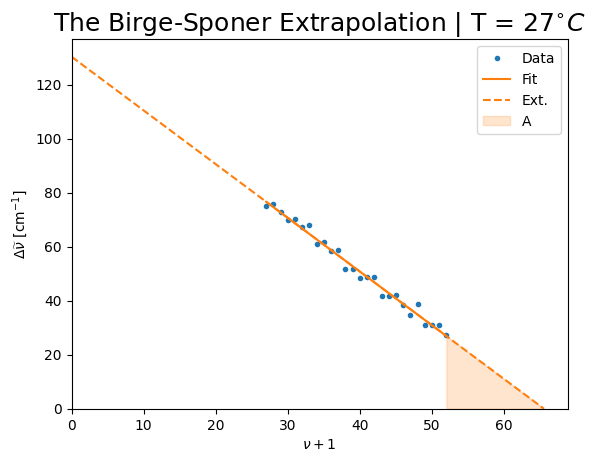

Results for T=27C:
ve = 130.33 ± 1.99 cm^-1
vexe = 0.99 ± 0.02 cm^-1
D0 = 4270.07 ± 168.53 cm^-1
De = 4335.23 ± 168.53 cm^-1
E* = 209.33 ± 9414.81 cm^-1


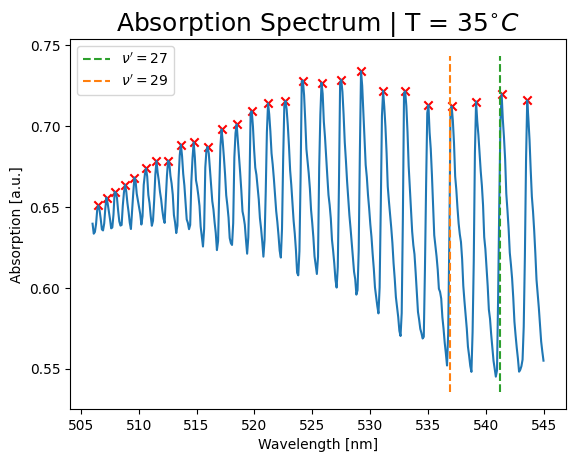

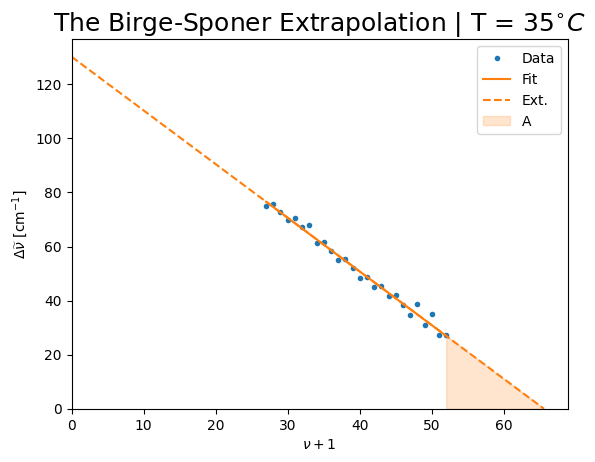

Results for T=35C:
ve = 130.23 ± 1.90 cm^-1
vexe = 0.99 ± 0.02 cm^-1
D0 = 4268.99 ± 160.73 cm^-1
De = 4334.11 ± 160.74 cm^-1
E* = 209.97 ± 9435.68 cm^-1


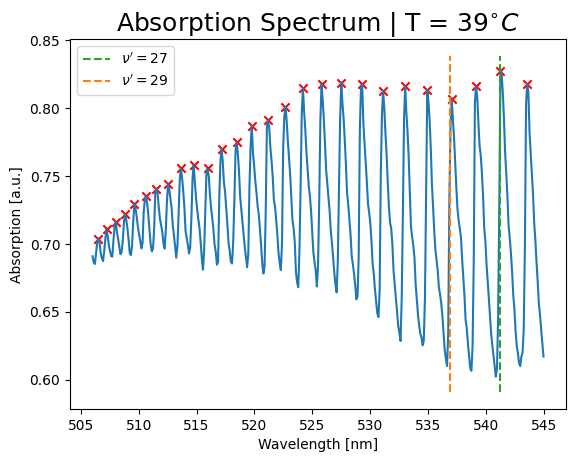

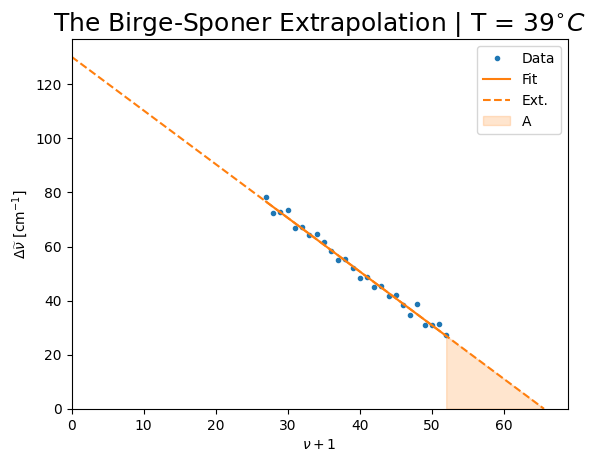

Results for T=39C:
ve = 130.22 ± 1.78 cm^-1
vexe = 0.99 ± 0.02 cm^-1
D0 = 4268.83 ± 150.45 cm^-1
De = 4333.94 ± 150.46 cm^-1
E* = 210.06 ± 9438.40 cm^-1


In [21]:
res_data = pd.DataFrame(columns = ['T', 've', 'dve', 'vexe', 'dvexe', 'D0', 'dD0', 'De', 'dDe', 'E_star', 'dE_star'])
for T in T_list:
    res = do_the_thing(T=T, n1 = 23, show_ext = True)
    res_data.loc[len(res_data)] = [T] + res

res_data.loc[len(res_data)] = res_data.mean()
res_data.loc[len(res_data)-1, 'T'] = 'mean'

In [22]:
display(res_data)
res_data.to_csv('Absorption_results.csv', index=False)

,T,ve,dve,vexe,dvexe,D0,dD0,De,dDe,E_star,dE_star
0,25.0,130.234758,1.909567,0.993270,0.023747,4269.002535,161.522108,4334.119914,161.524930,209.960243,9435.529619
1,27.0,130.329965,1.993726,0.994475,0.024794,4270.065502,168.527083,4335.230484,168.530031,209.331185,9414.808352
2,35.0,130.233872,1.900248,0.993259,0.023632,4268.992654,160.734855,4334.109590,160.737663,209.966105,9435.684204
3,39.0,130.219261,1.778516,0.993074,0.022118,4268.829701,150.453555,4333.939332,150.456183,210.062823,9438.396471
4,mean,130.254464,1.895514,0.993520,0.023573,4269.222598,160.309400,4334.349830,160.312202,209.830089,9431.104662
